In [20]:
import os
import time
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from statsmodels.formula.api import ols
%matplotlib inline
import tushare as ts
from turtle import color
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVR,SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import pdist, squareform

### Define function

In [ ]:
def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 

### Extract features for rental median

In [ ]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates()
df = df[['Suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['Suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df

In [ ]:
for suburb in [x for x in df.columns][1:]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df = df.fillna(0)
df

#### Predict rent for future 3 years

In [ ]:
from sklearn.linear_model import Ridge

train_x = df[['Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021']]
train_y = df['Rental_total_Jun_2021']

# split train test dataset
# x_train_rent, x_test_rent, y_train_rent, y_test_rent = train_test_split(train_x,train_y, train_size=0.7,test_size=0.3,random_state=42)

# set up ridge regression
ridge = Ridge(alpha=50)
ridge.fit(train_x, train_y)
pred=ridge.predict(train_x)
print("The score is: ", ridge.score(train_x, train_y))


# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

In [ ]:

# set up Lasso regression
lasso = Lasso(max_iter=300000, alpha = 0.01)
lasso.fit(train_x, train_y)
pred = lasso.predict(train_x)
print("The score is: ", lasso.score(train_x, train_y))


# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

In [ ]:
# since one year rental contains four sections
predict_X_train = train_x
predict_Y_train = train_y

for year in ['2021', '2022', '2023', '2024', '2025']:
    for month in ['Mar', 'Jun', 'Sep', 'Dec']:
        if year == "2021" and month == "Mar":
            continue
        lasso.fit(predict_X_train, predict_Y_train)
        pred =lasso.predict(predict_X_train)
        
        predict_X_train[f'Rental_total_{month}_{year}'] = predict_Y_train
        predict_Y_train = pred

 

In [ ]:
predict_X_train

In [ ]:
ridge = Ridge()
params = {
    "alpha": [0.005, 0.01, 1, 5, 10, 20, 50],
    "max_iter": [300000,30]
}
model1 = GridSearchCV(ridge, param_grid=params, cv=5, n_jobs=-1)
model1.fit(train_x, train_y)
model1.best_params_

#### Predict population for future 3 years

In [ ]:
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

### Feature Engineering

In [ ]:
# 9.29 start now:

In [ ]:
property_df = pd.read_csv('../data/curated/property_cleaned.csv', low_memory = False)
property_df['cloest_train_station'] = property_df['cloest_train_station'].apply(eval)
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [ ]:
# drop station for now
property_df_temp = property_df.drop(columns = ['cloest_train_station', 'cloest_tram_stop', 'cloest_bus_stop'])


In [ ]:
property_df_temp.columns

In [ ]:
Rental_list = []
Others = []
for col in property_df_temp.columns:
    if 'Rental' in col:
        Rental_list.append(col)
    else:
        Others.append(col)

In [ ]:
#Other_df = property_df_temp[Others].copy()
Other_df = property_df_temp.copy()
# replace type name
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat', 'Apartment / Unit / Flat / Penhouse')
Other_df['type'] = Other_df['type'].replace('Penthouse', 'Apartment / Unit / Flat / Penhouse')

# Change to numerical
Other_df = Other_df.replace('-', -1)

Other_df['furnitured'] = Other_df['furnitured'].replace('Yes', 1)
Other_df['furnitured'] = Other_df['furnitured'].replace('No', 0)

Other_df['pool'] = Other_df['pool'].replace('Yes', 1)
Other_df['pool'] = Other_df['pool'].replace('No', 0)

Other_df['gym'] = Other_df['gym'].replace('Yes', 1)
Other_df['gym'] = Other_df['gym'].replace('No', 0)

# fill
Other_df = Other_df.fillna(-1)

# drop
Other_df = Other_df.drop(columns=['postcode'])

In [ ]:
pie_data = Other_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,10))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [ ]:
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
Other_df['type'] = Other_df['type'].replace('Studio', 2)
Other_df['type'] = Other_df['type'].replace('Townhouse', 3)
Other_df['type'] = Other_df['type'].replace('House', 4)
Other_df['type'] = Other_df['type'].replace('Penthouse', 5)

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution', fontsize=18)
sns.histplot(Other_df['rent_weekly'])

In [ ]:
Other_df["rent_weekly"].describe()

In [ ]:
Q1 = Other_df["rent_weekly"].quantile(0.25)
Q3 = Other_df["rent_weekly"].quantile(0.75)
IQR = Q3 - Q1
Other_df = Other_df[~((Other_df["rent_weekly"] < (Q1 - 1.5 * IQR)) | (Other_df["rent_weekly"] > (Q3 + 1.5 * IQR)))]
Other_df = Other_df.reset_index(drop=True)

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent after delete outlier',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_after.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution after delete outlier', fontsize=18)
sns.distplot(Other_df['rent_weekly'])

In [ ]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

In [ ]:
Other_df = convert_suburb(Other_df)

In [ ]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [ ]:
# print(Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).to_dict())
#Other_df.corr().abs().sort_values(by=['rent_weekly'],ascending=True).iloc[0]

In [ ]:
other_lis = []
column_lis = []
for col in Other_df.columns:
    if (('Rental_total' in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        column_lis.append(col)
    else:
        other_lis.append(col)

In [ ]:
Other_df = Other_df[column_lis]

In [ ]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [ ]:
Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

In [ ]:
# chi2, mutual_info_classif, f_classif
X = Other_df.copy()
X = X.reset_index(drop=True)
Y = X['rent_weekly'].copy()
X = X.drop(columns=['rent_weekly','address','coordinates'])
x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

#### Define model

In [ ]:
def LR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [ ]:
def SVM_acc(x_train, x_test, y_train, y_test):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lsvc_clf.score(x_train, y_train)
    test_acc = lsvc_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def SVM_pred(x_train, x_test, y_train):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)
    # make a prediction
    pred = lsvc_clf.predict(x_test)
    
    return pred

In [ ]:
def LinearR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LinearR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [ ]:
def Lasso_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lasso_clf.score(x_train, y_train)
    test_acc = lasso_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Lasso_pred(x_train, x_test, y_train):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)
    # make a prediction
    pred = lasso_clf.predict(x_test)
    
    return pred

In [ ]:
def Ridge_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = ridge_clf.score(x_train, y_train)
    test_acc = ridge_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Ridge_pred(x_train, x_test, y_train):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)
    # make a prediction
    pred = ridge_clf.predict(x_test)
    
    return pred

In [ ]:
def GridSearch(pipeline, params, x, y):
    # initilized Grid Search
    grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)
    print("Pipeline: ", [i for i, _ in pipeline.steps])
    t=time.time()
    grid_search.fit(x,y)
    print("finish %0.2fs\n" % (time.time()-t))   #show the run time
    
    # show top 5 parameters
    mean_score = grid_search.cv_results_["mean_test_score"]
    parementer_ls = grid_search.cv_results_["params"]
    for i in mean_score.argsort()[-5:]:
        print(parementer_ls[i])
        print(mean_score[i])
        print("----"*30)
        
        
    return grid_search

#### Start to do modelling

In [ ]:
train_x_lis = []
for col in Other_df.columns:
    if (('Rental_total' not in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        train_x_lis.append(col)

In [ ]:
train_test_dataset = Other_df[train_x_lis]

In [ ]:
# # chi2, mutual_info_classif, f_classif
# X = train_test_dataset.copy()
# X = X.reset_index(drop=True)
# Y = X['rent_weekly'].copy()
# X = X.drop(columns=['rent_weekly','address','coordinates'])
# x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

In [ ]:
print("Linear Regression")
# check the time costed by model
%time

# using linear regression to test if the model is good for our dataset
clf = LinearRegression()
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

In [ ]:
# using lasso regression to test if the model is good for our dataset
print("Lasso Model")
# check the time costed by model
%time

# set max iter let the model go through all the train and test data
clf = Lasso()
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

In [ ]:
# using Ridge regression to test if the model is good for our dataset
print("Ridge Model")
# check the time costed by model
%time

# set max iter let the model go through all the train and test data
clf = Ridge(alpha=1)
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

## Predict

In [21]:
population_data = pd.read_csv("../data/curated/sa2.csv")

In [22]:
population_data.columns

Index(['SA2_Code', '2001_population', '2002_population', '2003_population',
       '2004_population', '2005_population', '2006_population',
       '2007_population', '2008_population', '2009_population',
       '2010_population', '2011_population', '2012_population',
       '2013_population', '2014_population', '2015_population',
       '2016_population', '2017_population', '2018_population',
       '2019_population', '2020_population', '2021_population',
       'Population_Change_no', 'Population_Change_percent',
       'Population_Area_km2', 'Population_density_2021_persons/km2',
       '2014-15_median_income', '2015-16_median_income',
       '2016-17_median_income', '2017-18_median_income',
       '2018-19_median_income', '2014-15_mean_income', '2015-16_mean_income',
       '2016-17_mean_income', '2017-18_mean_income', '2018-19_mean_income',
       'residential', 'primary_production', 'community_infrastructure',
       'mix_use', 'industrial', 'scenic_spot', 'commerical', 'utilities

In [23]:
# for income prediction
income_median_df = population_data[['2014-15_median_income', '2015-16_median_income',
                                    '2016-17_median_income', '2017-18_median_income',
                                    '2018-19_median_income']]
income_mean_df = population_data[['2014-15_mean_income', '2015-16_mean_income',
                                '2016-17_mean_income', '2017-18_mean_income', 
                                '2018-19_mean_income']]

### Predict population

In [24]:
population_history = []
population_history.append('SA2_Code')
for i in population_data.columns:
    if '_population' in i:
        population_history.append(i)

population_hist_data = population_data[population_history]

population_hist_data = population_hist_data.set_index('SA2_Code')

In [25]:
population_hist_data

,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2012_population,2013_population,2014_population,2015_population,2016_population,2017_population,2018_population,2019_population,2020_population,2021_population
SA2_Code,,,,,,,,,,,,,,,,,,,,,
101021007.0,2760.0,2811.0,2835.0,2844.0,2847.0,2965.0,3102.0,3181.0,3308.0,3429.0,...,3590.0,3685.0,3762.0,3849.0,3950.0,4039.0,4140.0,4211.0,4273.0,4330.0
101021008.0,9129.0,9199.0,9263.0,9277.0,9209.0,9212.0,9033.0,8994.0,9030.0,9101.0,...,9012.0,8848.0,8731.0,8603.0,8531.0,8526.0,8507.0,8488.0,8519.0,8546.0
101021009.0,9717.0,9513.0,9522.0,9400.0,9595.0,9682.0,9793.0,10074.0,10288.0,10584.0,...,10870.0,11050.0,11199.0,11213.0,11230.0,11355.0,11447.0,11450.0,11437.0,11370.0
101021010.0,3925.0,4073.0,4219.0,4218.0,4187.0,4319.0,4459.0,4595.0,4712.0,4813.0,...,4971.0,4983.0,4967.0,4961.0,4970.0,5013.0,5072.0,5117.0,5077.0,5093.0
101021012.0,9425.0,10257.0,11085.0,11549.0,12046.0,12358.0,12622.0,12798.0,12988.0,13146.0,...,13204.0,13210.0,13193.0,13164.0,13150.0,13083.0,13008.0,12935.0,12796.0,12743.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801111141.0,12.0,11.0,11.0,10.0,10.0,9.0,15.0,22.0,27.0,36.0,...,40.0,37.0,38.0,39.0,39.0,45.0,50.0,56.0,61.0,67.0
901011001.0,1442.0,1365.0,1337.0,1355.0,1380.0,1403.0,1569.0,1745.0,1944.0,2115.0,...,2107.0,2041.0,1979.0,1929.0,1903.0,1877.0,1849.0,1801.0,1752.0,1716.0
901021002.0,600.0,568.0,558.0,573.0,588.0,590.0,575.0,568.0,565.0,565.0,...,546.0,547.0,556.0,555.0,546.0,569.0,571.0,599.0,605.0,602.0


In [26]:
year = []
for i in population_hist_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))

In [27]:
# check 1st sa2code population
populationdata_in_each_sa2_code = pd.DataFrame()
populationdata_in_each_sa2_code['Population'] = population_hist_data.iloc[0].tolist()
populationdata_in_each_sa2_code['Year'] = year
populationdata_in_each_sa2_code

,Population,Year
0,2760.0,1
1,2811.0,2
2,2835.0,3
3,2844.0,4
4,2847.0,5
5,2965.0,6
6,3102.0,7
7,3181.0,8
8,3308.0,9
9,3429.0,10


In [28]:
# unique sa2 code population trend
sa1 = population_hist_data.iloc[0].tolist()
year = ['2001_population', '2002_population', '2003_population',
       '2004_population', '2005_population', '2006_population',
       '2007_population', '2008_population', '2009_population',
       '2010_population', '2011_population', '2012_population',
       '2013_population', '2014_population', '2015_population',
       '2016_population', '2017_population', '2018_population',
       '2019_population', '2020_population', '2021_population']

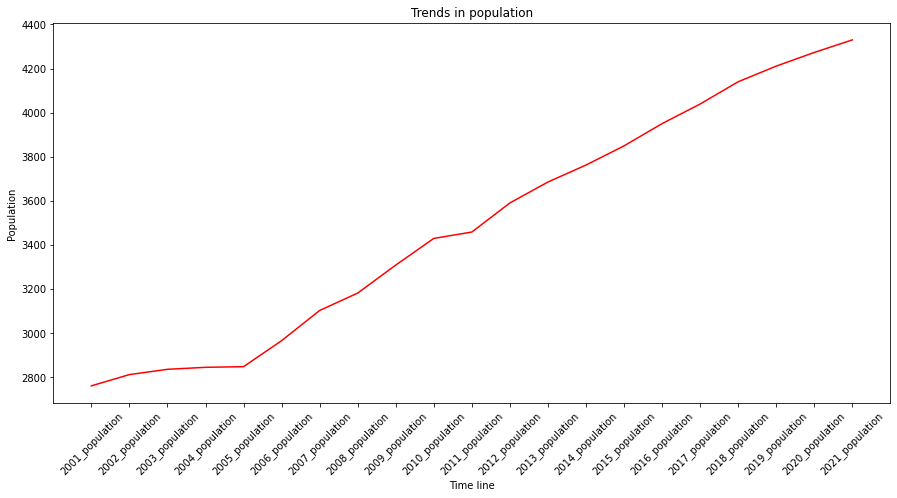

In [29]:
# plot population in one sa2 code
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Time line")
plt.title("Trends in population")
plt.plot(year,sa1, color = 'r')

In [30]:
# check 1st sa2code population
x = populationdata_in_each_sa2_code['Year']
y = populationdata_in_each_sa2_code['Population']
linear_model = sm.formula.ols('Population ~ Year', data = populationdata_in_each_sa2_code).fit()
print(linear_model.params)

Intercept    2541.461905
Year           86.572727
dtype: float64


In [31]:
predict_population = pd.DataFrame()
predict_year = [22,23,24,25,26,27]
predict_population['Year'] = predict_year
predict_population['Population'] = None
predict_population

,Year,Population
0,22,None
1,23,None
2,24,None
3,25,None
4,26,None
5,27,None


In [32]:
predicted_population = linear_model.predict(exog=predict_population['Year'], transform=True)
predicted_population

0    4446.061905
1    4532.634632
2    4619.207359
3    4705.780087
4    4792.352814
5    4878.925541
dtype: float64

In [68]:
train_predict_population = linear_model.predict(exog=x, transform=True)
# The mean squared error
print("Train mean squared error: %.2f" % mean_squared_error(y, train_predict_population))
rmse = np.sqrt(mean_squared_error(y, train_predict_population))
print("Train RMSE is: ", rmse)

Train mean squared error: 8628056.67
Train RMSE is:  2937.355386542833


In [34]:
predict_population['Population'] = predicted_population

In [35]:
dfs = [populationdata_in_each_sa2_code, predict_population]
five_years_population = pd.concat(dfs)

In [36]:
five_years_population.reset_index().drop(columns='index')
five_years_population['Year'] = ['2001_population', '2002_population', '2003_population',
       '2004_population', '2005_population', '2006_population',
       '2007_population', '2008_population', '2009_population',
       '2010_population', '2011_population', '2012_population',
       '2013_population', '2014_population', '2015_population',
       '2016_population', '2017_population', '2018_population',
       '2019_population', '2020_population', '2021_population',
       '2022_population', '2023_population', '2024_population',
       '2025_population', '2026_population', '2027_population']

In [37]:
five_years_population

,Population,Year
0,2760.000000,2001_population
1,2811.000000,2002_population
2,2835.000000,2003_population
3,2844.000000,2004_population
4,2847.000000,2005_population
5,2965.000000,2006_population
6,3102.000000,2007_population
7,3181.000000,2008_population
8,3308.000000,2009_population
9,3429.000000,2010_population


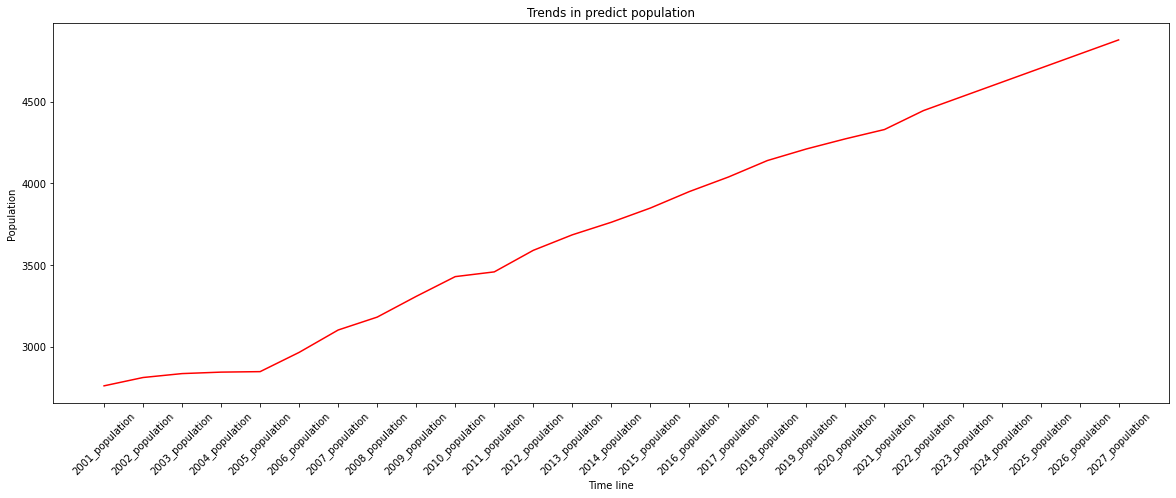

In [38]:
# plot predict population in one sa2 code
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Time line")
plt.title("Trends in predict population")
plt.plot(five_years_population['Year'],five_years_population['Population'], color = 'r')

In [39]:
All_sa2_code_predict_population = pd.DataFrame()
year = []
for i in population_hist_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))


predict_population_list = {}
for i in range(len(population_hist_data)):

    # create df ready to fit each row
    populationdata_in_each_sa2_code = pd.DataFrame()
    populationdata_in_each_sa2_code['Population'] = population_hist_data.iloc[i].tolist()
    populationdata_in_each_sa2_code['Year'] = year

    # create df ready to predict
    predict_population = pd.DataFrame()
    predict_year = [22,23,24,25,26,27]
    predict_population['Year'] = predict_year
    predict_population['Population'] = None
    
    # build linear model
    linear_model = sm.formula.ols('Population ~ Year', data = populationdata_in_each_sa2_code).fit()

    # predict population
    predicted_population = linear_model.predict(exog=predict_population['Year'], transform=True)
    # print(predicted_population)
    # put predicted population in df
    predict_population['Population'] = predicted_population

    # concat history population and predict population
    dfs = [populationdata_in_each_sa2_code, predict_population]
    five_years_population = pd.concat(dfs)
    five_years_population = five_years_population.reset_index().drop(columns='index')
    five_years_population['Year'] = ['2001_population', '2002_population', '2003_population',
                                    '2004_population', '2005_population', '2006_population',
                                    '2007_population', '2008_population', '2009_population',
                                    '2010_population', '2011_population', '2012_population',
                                    '2013_population', '2014_population', '2015_population',
                                    '2016_population', '2017_population', '2018_population',
                                    '2019_population', '2020_population', '2021_population',
                                    '2022_population', '2023_population', '2024_population',
                                    '2025_population', '2026_population', '2027_population']
                                    
    five_years_population['SA2_Code'] = population_hist_data.index[i]

    predict_population_list[i] = five_years_population
    # predict_population_list.append(five_years_population)

In [40]:
predict_population_list[0].transpose()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Population,2760.0,2811.0,2835.0,2844.0,2847.0,2965.0,3102.0,3181.0,3308.0,3429.0,...,4140.0,4211.0,4273.0,4330.0,4446.061905,4532.634632,4619.207359,4705.780087,4792.352814,4878.925541
Year,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2018_population,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population
SA2_Code,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,...,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0


In [41]:
predict_population_df = pd.DataFrame()
predict_population_df = predict_population_list[0].transpose()
for i in range(1, len(predict_population_list)):
    # print(i)
    predict_population_df = predict_population_df.append(predict_population_list[i].transpose())
predict_population_df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Population,2760.0,2811.0,2835.0,2844.0,2847.0,2965.0,3102.0,3181.0,3308.0,3429.0,...,4140.0,4211.0,4273.0,4330.0,4446.061905,4532.634632,4619.207359,4705.780087,4792.352814,4878.925541
Year,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2018_population,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population
SA2_Code,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,...,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0,101021007.0
Population,9129.0,9199.0,9263.0,9277.0,9209.0,9212.0,9033.0,8994.0,9030.0,9101.0,...,8507.0,8488.0,8519.0,8546.0,8411.833333,8367.670996,8323.508658,8279.34632,8235.183983,8191.021645
Year,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2018_population,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2018_population,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population
SA2_Code,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,...,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0,901031003.0
Population,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1920.0,1999.0,2096.0,2220.0,1851.995238,1969.193939,2086.392641,2203.591342,2320.790043,2437.988745
Year,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2018_population,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population


In [42]:
population_data['SA2_Code'].astype('str')

0       101021007.0
1       101021008.0
2       101021009.0
3       101021010.0
4       101021012.0
           ...     
2449    801111141.0
2450    901011001.0
2451    901021002.0
2452    901031003.0
2453    901041004.0
Name: SA2_Code, Length: 2454, dtype: object

In [44]:
year_list = predict_population_df.loc['Year'].iloc[0].tolist()

final_predict_population_df = pd.DataFrame()

final_predict_population_df = predict_population_df.loc['Population']
final_predict_population_df.index = population_data['SA2_Code'].astype('str')
final_predict_population_df.columns = year_list
final_predict_population_df

,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2018_population,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population
SA2_Code,,,,,,,,,,,,,,,,,,,,,
101021007.0,2760.0,2811.0,2835.0,2844.0,2847.0,2965.0,3102.0,3181.0,3308.0,3429.0,...,4140.0,4211.0,4273.0,4330.0,4446.061905,4532.634632,4619.207359,4705.780087,4792.352814,4878.925541
101021008.0,9129.0,9199.0,9263.0,9277.0,9209.0,9212.0,9033.0,8994.0,9030.0,9101.0,...,8507.0,8488.0,8519.0,8546.0,8411.833333,8367.670996,8323.508658,8279.34632,8235.183983,8191.021645
101021009.0,9717.0,9513.0,9522.0,9400.0,9595.0,9682.0,9793.0,10074.0,10288.0,10584.0,...,11447.0,11450.0,11437.0,11370.0,11873.009524,11993.482251,12113.954978,12234.427706,12354.900433,12475.37316
101021010.0,3925.0,4073.0,4219.0,4218.0,4187.0,4319.0,4459.0,4595.0,4712.0,4813.0,...,5072.0,5117.0,5077.0,5093.0,5355.661905,5415.289177,5474.91645,5534.543723,5594.170996,5653.798268
101021012.0,9425.0,10257.0,11085.0,11549.0,12046.0,12358.0,12622.0,12798.0,12988.0,13146.0,...,13008.0,12935.0,12796.0,12743.0,13833.680952,13957.162771,14080.644589,14204.126407,14327.608225,14451.090043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801111141.0,12.0,11.0,11.0,10.0,10.0,9.0,15.0,22.0,27.0,36.0,...,50.0,56.0,61.0,67.0,63.161905,65.977489,68.793074,71.608658,74.424242,77.239827
901011001.0,1442.0,1365.0,1337.0,1355.0,1380.0,1403.0,1569.0,1745.0,1944.0,2115.0,...,1849.0,1801.0,1752.0,1716.0,2054.138095,2081.674459,2109.210823,2136.747186,2164.28355,2191.819913
901021002.0,600.0,568.0,558.0,573.0,588.0,590.0,575.0,568.0,565.0,565.0,...,571.0,599.0,605.0,602.0,574.07619,574.28658,574.49697,574.707359,574.917749,575.128139


In [45]:
final_predict_population_df.to_csv('../data/curated/predicted_population.csv')

### Predict income

### Predict affordable

In [53]:
affordable_df = pd.read_csv("../data/curated/affordable.csv")

In [54]:
affordable_df.shape

(82, 436)

In [55]:
affordable_1r_df = affordable_df.loc[:, 'Percent_1r_Mar_2000':'Percent_1r_Sep_2021']
affordable_2r_df = affordable_df.loc[:, 'Percent_2r_Mar_2000':'Percent_2r_Sep_2021']
affordable_3r_df = affordable_df.loc[:, 'Percent_3r_Mar_2000':'Percent_3r_Sep_2021']
affordable_4r_df = affordable_df.loc[:, 'Percent_4r_Mar_2000':'Percent_4r_Sep_2021']
affordable_total_df = affordable_df.loc[:, 'Percent_total_Mar_2000':'Percent_total_Sep_2021']
LGA = affordable_df['LGA']
LGA

0           Alpine
1           Ararat
2         Ballarat
3          Banyule
4       Bass Coast
          ...     
77    Yarra Ranges
78    Yarriambiack
79     Table Total
80           Metro
81       Non-Metro
Name: LGA, Length: 82, dtype: object

In [56]:
# affordable_1r_value = affordable_1r_df.iloc[0,:].to_list()
# affordable_2r_value = affordable_2r_df.iloc[0,:].to_list()
affordable_total_value = affordable_total_df.iloc[2,:].to_list()
# affordable_timestep = affordable_total_df.columns.to_list()
# affordable_timestep

In [57]:
affordable_timestep = affordable_total_df.columns.to_list()
affordable_timestep

['Percent_total_Mar_2000',
 'Percent_total_Jun_2000',
 'Percent_total_Sep_2000',
 'Percent_total_Dec_2000',
 'Percent_total_Mar_2001',
 'Percent_total_Jun_2001',
 'Percent_total_Sep_2001',
 'Percent_total_Dec_2001',
 'Percent_total_Mar_2002',
 'Percent_total_Jun_2002',
 'Percent_total_Sep_2002',
 'Percent_total_Dec_2002',
 'Percent_total_Mar_2003',
 'Percent_total_Jun_2003',
 'Percent_total_Sep_2003',
 'Percent_total_Dec_2003',
 'Percent_total_Mar_2004',
 'Percent_total_Jun_2004',
 'Percent_total_Sep_2004',
 'Percent_total_Dec_2004',
 'Percent_total_Mar_2005',
 'Percent_total_Jun_2005',
 'Percent_total_Sep_2005',
 'Percent_total_Dec_2005',
 'Percent_total_Mar_2006',
 'Percent_total_Jun_2006',
 'Percent_total_Sep_2006',
 'Percent_total_Dec_2006',
 'Percent_total_Mar_2007',
 'Percent_total_Jun_2007',
 'Percent_total_Sep_2007',
 'Percent_total_Dec_2007',
 'Percent_total_Mar_2008',
 'Percent_total_Jun_2008',
 'Percent_total_Sep_2008',
 'Percent_total_Dec_2008',
 'Percent_total_Mar_2009',
 

In [58]:
affordable_month_list = []
for year in range(22):
    for month in range(3,15,3):
        if year == 21 and month == 12:
            break
        else:
            months = year * 12 + month
            affordable_month_list.append(months)
            # print(year,'-',month)
affordable_month_list

[3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 27,
 30,
 33,
 36,
 39,
 42,
 45,
 48,
 51,
 54,
 57,
 60,
 63,
 66,
 69,
 72,
 75,
 78,
 81,
 84,
 87,
 90,
 93,
 96,
 99,
 102,
 105,
 108,
 111,
 114,
 117,
 120,
 123,
 126,
 129,
 132,
 135,
 138,
 141,
 144,
 147,
 150,
 153,
 156,
 159,
 162,
 165,
 168,
 171,
 174,
 177,
 180,
 183,
 186,
 189,
 192,
 195,
 198,
 201,
 204,
 207,
 210,
 213,
 216,
 219,
 222,
 225,
 228,
 231,
 234,
 237,
 240,
 243,
 246,
 249,
 252,
 255,
 258,
 261]

In [59]:
affordable_year_list = [i for i in range(22)]
affordable_year_1r_value = []
affordable_year_2r_value = []
affordable_year_total_value = []

index = 0
for year in affordable_year_list:
    if year == 21:
        # affordable_year_1r_value.append(np.mean(affordable_1r_value[index:index+3]))
        # affordable_year_2r_value.append(np.mean(affordable_2r_value[index:index+3]))
        affordable_year_total_value.append(np.mean(affordable_total_value[index:index+3]))
    else:
        # affordable_year_1r_value.append(np.mean(affordable_1r_value[index:index+4]))
        # affordable_year_2r_value.append(np.mean(affordable_2r_value[index:index+4]))
        affordable_year_total_value.append(np.mean(affordable_total_value[index:index+4]))
    index += 4
# affordable_year_total_value

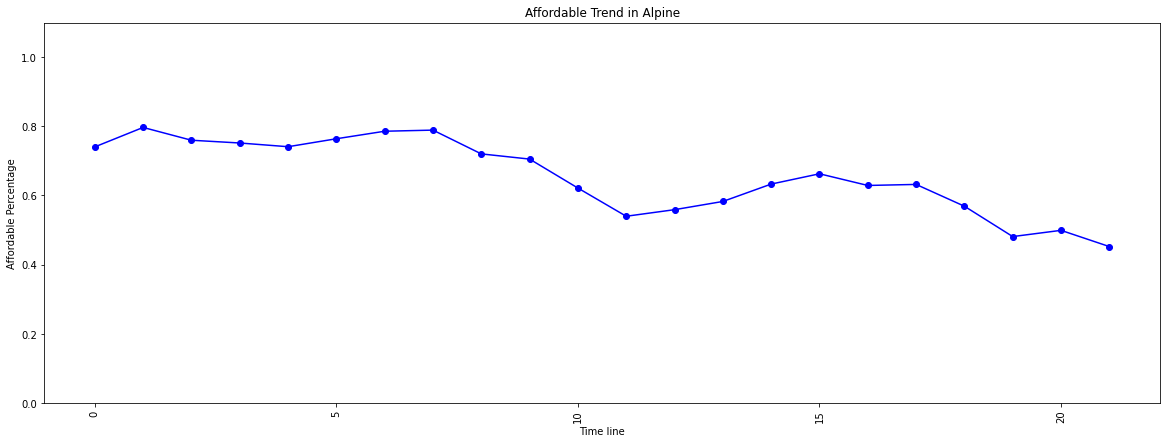

In [60]:
# plot predict population in one sa2 code
from matplotlib import markers


plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.ylabel("Affordable Percentage")
plt.xlabel("Time line")
plt.title("Affordable Trend in Alpine")
# month plot
# plt.scatter(affordable_timestep, affordable_1r_value, color = 'r')
# plt.plot(affordable_timestep, affordable_1r_value, color = 'r')
# plt.plot(affordable_timestep, affordable_2r_value, color = 'g')
# plt.plot(affordable_timestep, affordable_total_value, color = 'b')

# year plot
# plt.plot(affordable_year_list, affordable_year_1r_value, color = 'b')
plt.plot(affordable_year_list, affordable_year_total_value, color = 'b', marker='o')
plt.ylim(0, 1.1)
plt.show()

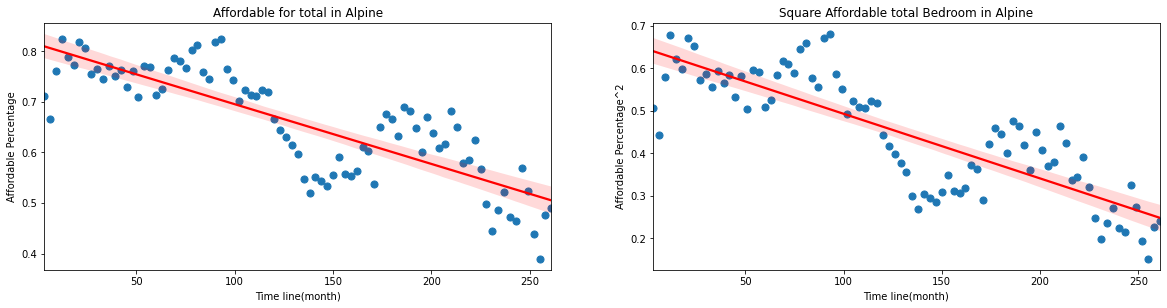

In [61]:
plt.figure(figsize=(20,10))
# sns.regplot(x=affordable_month_list, y=affordable_1r_value, line_kws={'color': 'r'}, 
#             x_estimator=np.mean)
# sns.regplot(x=affordable_month_list, y=affordable_2r_value, line_kws={'color': 'r'}, 
#             x_estimator=np.mean)
plt.subplot(221)
sns.regplot(x=affordable_month_list, y=affordable_total_value, line_kws={'color': 'r'}, 
            x_estimator=np.mean)
plt.title('Affordable for total in Alpine')
plt.ylabel("Affordable Percentage")
plt.xlabel("Time line(month)")

plt.subplot(222)
sns.regplot(x=affordable_month_list, y=np.power(affordable_total_value, 2), line_kws={'color': 'r'}, 
            x_estimator=np.mean)
plt.title('Square Affordable total Bedroom in Alpine')
plt.ylabel("Affordable Percentage^2")
plt.xlabel("Time line(month)")
plt.show()

In [62]:
affordable_timestep[:4][3][:-2]

'Percent_total_Dec_20'

In [63]:
affordable_predict_month_list = []
affordable_total_time = affordable_timestep.copy()

i = 0
for year in range(21, 28):
    for month in range(3,15,3):
        if month == 3:
            i = 0
        elif month == 6:
            i += 1
        elif month == 9:
            i += 1
        else:
            i += 1
        
        if year == 21:
            if month != 12:
                continue
            else:
                months = year * 12 + month
                category = affordable_timestep[:4][i][:-2] + str(year)
                affordable_total_time.append(category)
                affordable_predict_month_list.append(months)
        else:
            months = year * 12 + month
            category = affordable_timestep[:4][i][:-2] + str(year)
            affordable_total_time.append(category)
            affordable_predict_month_list.append(months)
# affordable_predict_month_list

built model

In [64]:
affordable_total_value = affordable_total_df.iloc[2,:].to_list()

In [65]:
affordable_train_df = pd.DataFrame()
affordable_predict_df = pd.DataFrame()
affordable_train_df['Month'] = affordable_month_list
# affordable_train_df['Affordable'] = np.power(affordable_total_value, 2)
affordable_train_df['Affordable'] = affordable_total_value
affordable_predict_df['Month'] = affordable_predict_month_list

linear_model_1 = sm.formula.ols('Affordable ~ Month', data = affordable_train_df).fit()
predicted_population_1 = linear_model_1.predict(exog=affordable_predict_df['Month'], transform=True)
affordable_predict_df['Affordable'] = predicted_population_1

In [67]:
# check the performance of model
train_predict_affordable = linear_model_1.predict(exog=affordable_train_df, transform=True)
# The mean squared error
print("Train mean squared error: %.2f" % mean_squared_error(affordable_total_value, train_predict_affordable))
rmse = np.sqrt(mean_squared_error(affordable_total_value, train_predict_affordable))
print("Train RMSE is: ", rmse)

Train mean squared error: 0.00
Train RMSE is:  0.06127028740840288


In [69]:
affordable_total_time

['Percent_total_Mar_2000',
 'Percent_total_Jun_2000',
 'Percent_total_Sep_2000',
 'Percent_total_Dec_2000',
 'Percent_total_Mar_2001',
 'Percent_total_Jun_2001',
 'Percent_total_Sep_2001',
 'Percent_total_Dec_2001',
 'Percent_total_Mar_2002',
 'Percent_total_Jun_2002',
 'Percent_total_Sep_2002',
 'Percent_total_Dec_2002',
 'Percent_total_Mar_2003',
 'Percent_total_Jun_2003',
 'Percent_total_Sep_2003',
 'Percent_total_Dec_2003',
 'Percent_total_Mar_2004',
 'Percent_total_Jun_2004',
 'Percent_total_Sep_2004',
 'Percent_total_Dec_2004',
 'Percent_total_Mar_2005',
 'Percent_total_Jun_2005',
 'Percent_total_Sep_2005',
 'Percent_total_Dec_2005',
 'Percent_total_Mar_2006',
 'Percent_total_Jun_2006',
 'Percent_total_Sep_2006',
 'Percent_total_Dec_2006',
 'Percent_total_Mar_2007',
 'Percent_total_Jun_2007',
 'Percent_total_Sep_2007',
 'Percent_total_Dec_2007',
 'Percent_total_Mar_2008',
 'Percent_total_Jun_2008',
 'Percent_total_Sep_2008',
 'Percent_total_Dec_2008',
 'Percent_total_Mar_2009',
 

In [70]:
affordable_train_df

,Month,Affordable
0,3,0.711
1,6,0.666
2,9,0.761
3,12,0.824
4,15,0.788
...,...,...
82,249,0.524
83,252,0.439
84,255,0.390
85,258,0.477


In [71]:
affordable_predict_df

,Month,Affordable
0,264,0.501612
1,267,0.498067
2,270,0.494522
3,273,0.490977
4,276,0.487432
5,279,0.483887
6,282,0.480341
7,285,0.476796
8,288,0.473251
9,291,0.469706


In [72]:
affordable_final_list = affordable_total_value.copy()
affordable_final_month = affordable_month_list.copy()
for i in range(len(predicted_population_1)):
    # affordable_final_list.append(np.sqrt(predicted_population_1[i]))
    affordable_final_list.append(predicted_population_1[i])
    affordable_final_month.append(affordable_predict_month_list[i])


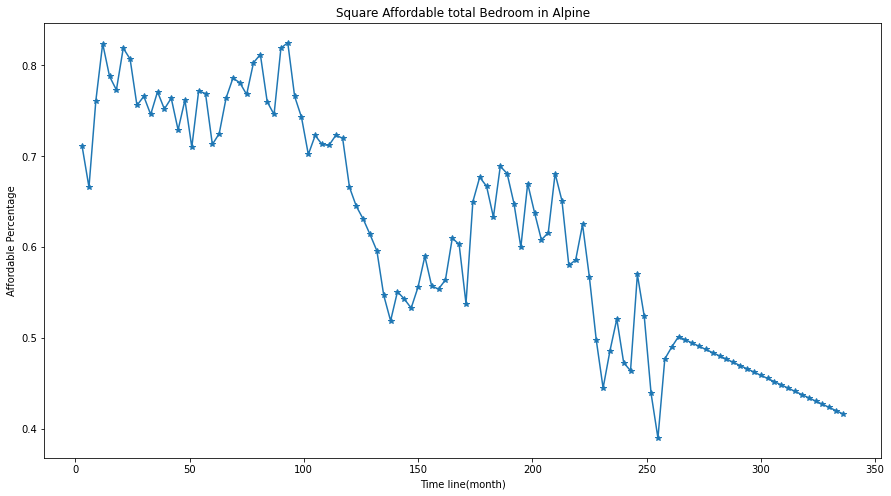

In [73]:
plt.figure(figsize=(15,8))
plt.plot(affordable_final_month, affordable_final_list, marker='*')
plt.title('Square Affordable total Bedroom in Alpine')
plt.ylabel("Affordable Percentage")
plt.xlabel("Time line(month)")
plt.show()

### Predict house price

## k best

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", LinearRegression())])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", SVC(max_iter = 20000))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", Lasso(alpha=1.0))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", Ridge(alpha=1.0))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
#Select features by chi-square with data after word vectorization

# fit data for Bow
kbest = SelectKBest(score_func = , k = ).fit(x_train, y_train)

# transform data
kbest_train_x = kbest.transform(x_train)
kbest_test_x = kbest.transform(x_test)


In [ ]:
LR = {}
print("The accuracy of LogisticRegression")
train_acc, test_acc = LR_acc(x_train, x_test, y_train, y_test)
LR["train_acc"] = train_acc
LR["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

SVM = {}
print("The accuracy of SVM")
train_acc, test_acc = SVM_acc(x_train, x_test, y_train, y_test)
SVM["train_acc"] = train_acc
SVM["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

LinearR = {}
print("The accuracy of LinearRegression")
train_acc, test_acc = LinearR_acc(x_train, x_test, y_train, y_test)
LinearR["train_acc"] = train_acc
LinearR["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

ridge = {}
print("The accuracy of Ridge")
train_acc, test_acc = Ridge_acc(x_train, x_test, y_train, y_test)
ridge["train_acc"] = train_acc
ridge["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

lasso = {}
print("The accuracy of Lasso")
train_acc, test_acc = Lasso_acc(x_train, x_test, y_train, y_test)
lasso["train_acc"] = train_acc
lasso["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

In [ ]:
acc_dict = [LR, SVM, LinearR, ridge,lasso]
index = ["LogisticRegression", "SVM", "LinearRegression", "Ridge", "Lasso"]
data = [[0,0],[0,0],[0,0],[0,0],[0,0]]
acc_df = pd.DataFrame(data, columns=['train_acc','test_acc'], index =index)

for i in range(5):
    model_name = index[i]
    acc_df.loc[model_name] = list(acc_dict[i].values())

In [ ]:
display(acc_df.sort_values(by=['test_acc'],ascending=False))

In [ ]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))